# Exemplo de deteção de contornos

Este é um exemplo de deteção de contornos e de círculos em que os *defaults* falharam e foi preciso fazer vários ajustes.

Neste exemplo vamos tentar 2 abordagems:

* Melhorando os valores do `inRange` e fazendo o *fine tuning* das imagens subsequentes
* Introduzindo operadores morfológicos de dilatação e erosão

### Conteúdo

[Imagem de testes e cor do color picker](#img_inicial)

[Problemas com a filtragem simples](#problemas)

[Análise dos canais H, S e V](#analise_canais)

[Novos valores para o inRange](#novos_inrange)

[Limpeza via operações morfológicas](#morphologia)

[Deteção de contornos e centro de massa](#contornos)

[Centro de massa de um contorno](#centro_massa)



## Imports

In [11]:
import auxiliar as aux
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

Versão da OpenCV

In [8]:
cv2.__version__

'4.5.3'

Diretório de trabalho:

In [9]:
print(os.getcwd())

c:\Users\diego\OneDrive\Documents\Main\GITHUB\robotica-computacional\docs\modulos\02-modelo-de-camera


<a id="img_inicial"></a>

<a name="img_inicial"/>

## Imagem de testes

Vamos praticar alguns conceitos vistos na imagem abaixo

![](img/stars.png)

In [12]:
img_bgr = cv2.imread("img/stars.png")
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

<a id="problemas"></a>
    

## Problemas com uma filtragem simples

Observando a imagem, podemos tentar uma filtragem simples, filtrando a cor vermelha.

Revisando o modelo de cores HSV, sabemos que o vermelho está entre 0 e 30.

![](img/hsv_circle.jfif)

Lembre-se que o OpenCV trabalha com o intervalo de 0 a 180 para o H. Portanto deveremos filtrar os valores entre ...?

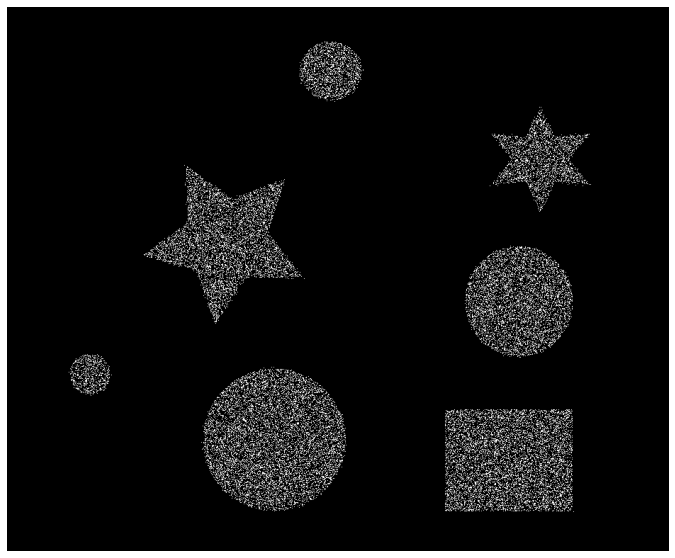

In [17]:
lower = np.array([0, 50, 50])
upper = np.array([15, 255, 255])
mascara = cv2.inRange(img_hsv, cor1, cor2)

plt.figure(figsize=(15,10))
plt.imshow(mascara, cmap="gray", vmin=0, vmax=255)
plt.axis("off")
plt.show()

A imagem acima nos mostra que a filtragem **não ficou muito boa**. Isso é um sinal de que precisamos tentar melhorar o resultado do `inRange`.

Podemos tentar usar tentativa e erro, ou podemos tentar fazer um *histograma* para entender onde nossa máscara não ficou boa.

Na aula 1 vimos como fazer um histograma. As funções abaixo foram baseadas no exemplo de histograma dado naquela aula

<a id="analise_canais"></a>

## Análise dos canais

Vamos usar seguidamente as funções a seguir para mostrar os canais H, S e V separadamente e também as imagens com cada canal em isolamento.

Estas funções são baseadas no material da aula 1.

In [ ]:
def hsv_hists(img, plt):
    """
        Plota o histograma de cada um dos canais HSV
        img - imagem HSV
        plt - objeto matplotlib
    """
    plt.figure(figsize=(20,10)); 
    img_h = img[:,:,0]
    img_s = img[:,:,1]
    img_v = img[:,:,2]
    histo_plot(img_h, "r","H", plt);
    histo_plot(img_s, "g","S", plt);
    histo_plot(img_v, "b","V", plt);

def make_hist(img_255, c, label, plt):
    """ img_255 - uma imagem com 3 canais de 0 até 255
        c a cor do plot
        label - o label do gráfico
        plt - matplotlib.pyplot
    """
    hist,bins = np.histogram(img_255.flatten(),256,[0,256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max()/ cdf.max()

    # plt.plot(cdf_normalized, color = c)
    plt.hist(img_255.flatten(),256,[0,256], color = c)
    plt.xlim([0,256])
    plt.legend(label, loc = 'upper left')
    plt.plot()

def histo_plot(img, cor, label, plt):
    """
        img - imagem
        cor - cor
        plt - matplotlib.pyplot object

    """
    plt.figure(figsize=(10,5))
    make_hist(img, cor, label, plt)
    plt.show()
    plt.figure(figsize=(10,5))
    plt.imshow(img, cmap="Greys_r")#, vmin=0, vmax=255)    
    plt.title(label)


Vamos agora usar as funções acima para fazer um histograma e ver a imagem em cada um dos canais

<Figure size 1440x720 with 0 Axes>

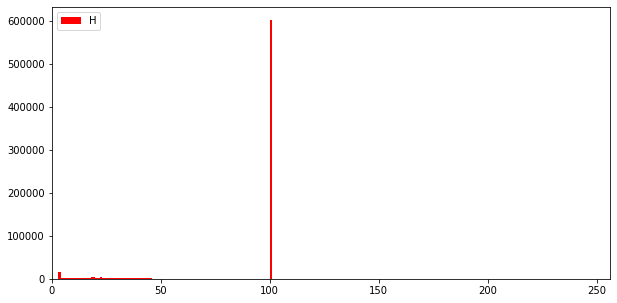

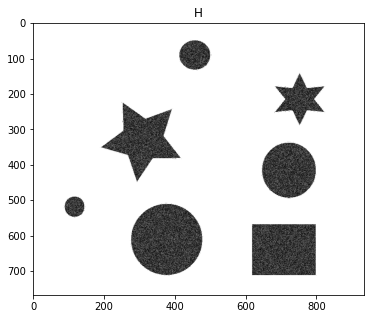

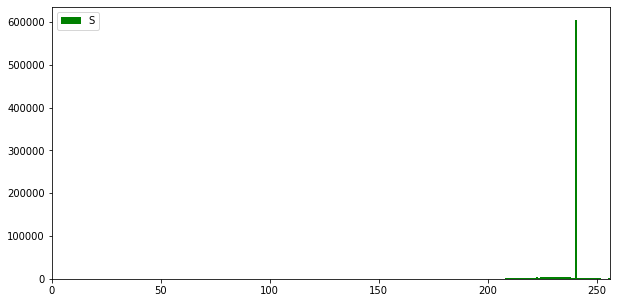

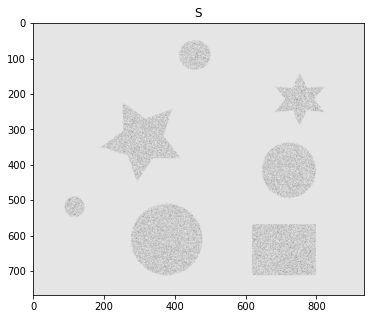

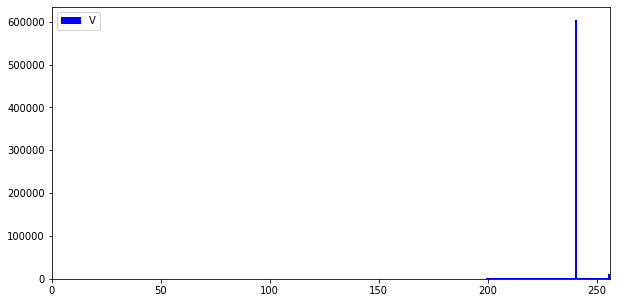

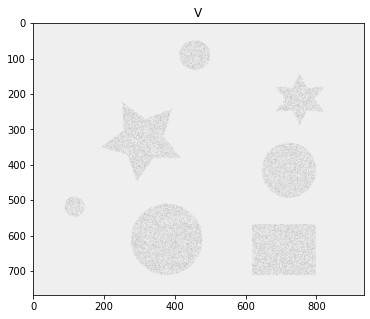

In [ ]:
hsv_hists(img_hsv, plt)

<a id="novos_inrange"></a>

## Novos valores para o inRange

Notemos que a componente *H* gerada para a cor vermelha, que está contida na faixa $[0,15]$, entretanto uma análise desta componente nos histogramas acima mostra:

* uma grande concentração acima do $50$
* a imagem do fundo azulado aparece mais clara no canal *H*, indicando que os pixels azuis são esta grande concentração acima do 50.
* uma concentração bem menor espalhada aproximadamente na faixa $[0,40]$
* A imagem do canal *H* mostra que os pixels das figuras são mais escuros neste canal. Provavelmente são as figuras que estão entre $0$ e $40$

A conclusão a que chegamos é que precisamos de uma faixa *H* para o `inRange` um pouco mais abrangente. Vamos tentar com os valores abaixo.

**Observe como se declaram arrays do numpy com o tipo adequado**

Basta incluir a especificação do pacote `np` antes de `np.array` e `np.uint8`.

In [ ]:
cor1_v2 = np.array([ 0, 50, 50], dtype=np.uint8)
cor2_v2 = np.array([ 45, 255, 255], dtype=np.uint8)

Vamos agora aplicar as novas faixas para obter uma nova máscara

In [ ]:
mascara_2 = cv2.inRange(img_hsv, cor1_v2, cor2_v2)

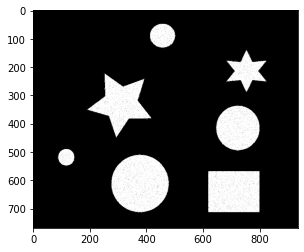

In [ ]:
plt.imshow(mascara_2, cmap="Greys_r", vmin=0, vmax=255)

**Sucesso!** Note que a filtragem ficou bem melhor agora

Ainda assim há pequenos furinhos na imagem. Podemos tentar eliminá-los com um pouco de *blur* ou [operações morfológicas](#morfologia)

<a name="morfologia" />


## Limpeza via operações morfológicas

Vamos usar as operações morfológica de *fechamento*.  Esta operação preenche todos os buracos menores que um dado `kernel`e depois corrói suas bordas com outro `kernel`. 

In [ ]:
kernel_dilate = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
cruz = ((0,1,0),(1,1,1),(0,1,0))
kernel_erode = np.array(cruz,np.uint8)


Vamos ver como ficam os *kernels* de dilatação e erosão, que são uma elipse e uma cruz, respectivamente

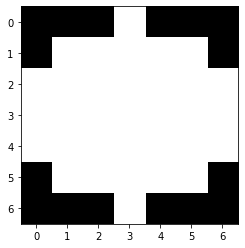

In [ ]:
plt.imshow(kernel_dilate, cmap = "gray")
plt.show()

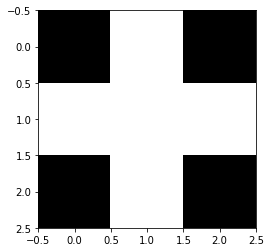

In [ ]:
plt.imshow(kernel_erode, cmap="gray")
plt.show()

In [ ]:
# O parâmetro opcional iterations permite que a mesma operação seja executada mais de uma vez seguidamente
morphology_dilate = cv2.dilate(mascara, kernel_dilate)#, iterations=2)

In [ ]:
morphology_erode = cv2.erode(morphology_dilate, kernel_erode)

Na Figura a seguir vemos na parte **esquerda** o resultado da dilatação e na **direita** o resultado da erosão.

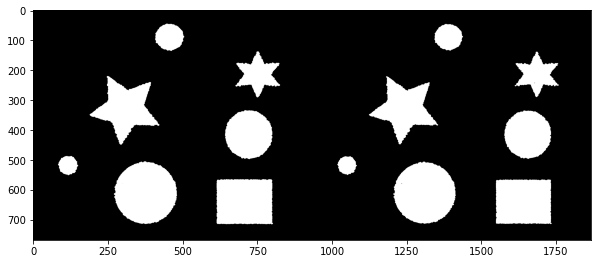

In [ ]:
plt.figure(figsize=(10,7))
plt.imshow(np.hstack((morphology_dilate, morphology_erode)), cmap="Greys_r")

**Sucesso!** Agora é só encontrar os contornos mais limpos.

Talvez você note pequenos buracos que ainda sobraram. Como exercício, tente mexer no tamanho do elemento estruturante de dilatação para tentar tapar esses buracos.

<a id="contornos"></a>

## Deteção de contornos e cálculo do centro de massa

Vamos aplicar uma deteção de contornos igual ao exemplo da aula 2

In [ ]:
mask = morphology_erode
contornos, arvore = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 

Precisamos criar uma cópia da máscara para fins de desenho:

In [ ]:
mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB) 
contornos_img = mask_rgb.copy() # Cópia da máscara para ser desenhada "por cima"


Vamos verificar os contornos detectados

In [ ]:
cv2.drawContours(contornos_img, contornos, -1, [255, 0, 0], 5);

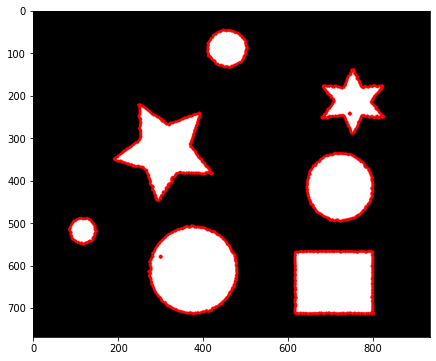

In [ ]:
plt.figure(figsize=(8,6))
plt.imshow(contornos_img);

<a id="centro_massa"></a>

### Centro de massa de um contorno

Muitas vezes é útil sabermos qual é o *centro de massa* de um contorno. Para esta finalidade vamos definir a função a seguir, que funciona tanto para contornos quanto para mascaras.

In [ ]:
def center_of_contour(contorno):
    """ Retorna uma tupla (cx, cy) que desenha o centro do contorno"""
    M = cv2.moments(contorno)
    # Usando a expressão do centróide definida em: https://en.wikipedia.org/wiki/Image_moment
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    return (int(cX), int(cY))
    
def crosshair(img, point, size, color):
    """ Desenha um crosshair centrado no point.
        point deve ser uma tupla (x,y)
        color é uma tupla R,G,B uint8
    """
    x,y = point
    cv2.line(img,(x - size,y),(x + size,y),color,5)
    cv2.line(img,(x,y - size),(x, y + size),color,5)
    
font = cv2.FONT_HERSHEY_SIMPLEX

def texto(img, a, p):
    """Escreve na img RGB dada a string a na posição definida pela tupla p"""
    cv2.putText(img, str(a), p, font,1,(0,50,100),2,cv2.LINE_AA)


Vamos percorrer a lista de contornos e aplicar as funções de centro de massa definidas acima

In [ ]:
for c in contornos:
    a = cv2.contourArea(c) # área
    p = center_of_contour(c) # centro de massa
    crosshair(contornos_img, p, 20, (128,128,0))
    texto(contornos_img, np.round(a,2),p)

Vamos verificar e desenhar o centro dos contornos e a área de cada círculo próxima de si.

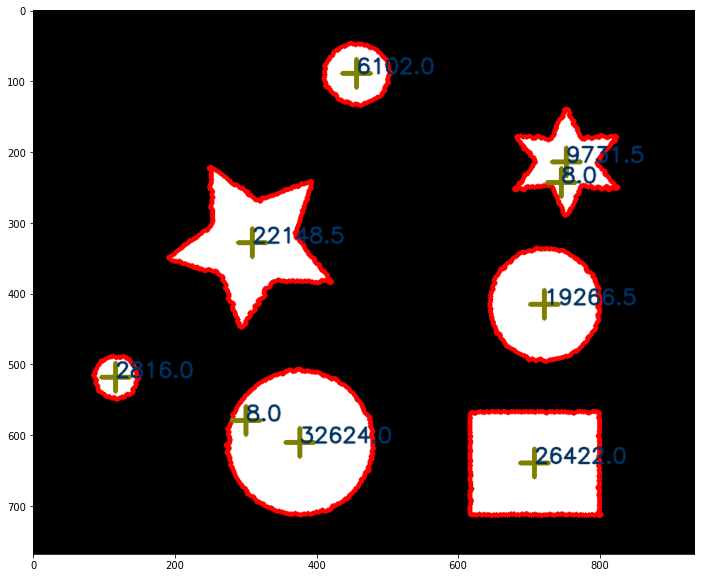

In [ ]:
plt.figure(figsize=(14,10))

plt.imshow(contornos_img);